In [1]:
import os
import cv2
import open3d as o3d
import torch
import json
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import data_conversion
import depth_anything_interface

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2024-10-09 08:40:18,046 - topics - topicmanager initialized


In [2]:
FRAME_INDEX = 0
GAP_INDEX = 20
MODEL_PATH = "/scratchdata/depth_anything_v2_metric_hypersim_vitl.pth"
model = depth_anything_interface.get_model("cuda", MODEL_PATH, model_type = "metric", encoder='vitl')

RATIO_THRESHOLD = 0.25

# Open bag file
bag_file_path = "/scratchdata/indoor_short.bag"
bag = rosbag.Bag(bag_file_path)

WARNING - 2024-10-09 08:40:18,738 - attention - xFormers not available
WARNING - 2024-10-09 08:40:18,740 - block - xFormers not available
INFO - 2024-10-09 08:40:18,762 - dinov2 - using MLP layer as FFN
/deep_stereo_ws/src/scripts/depth_anything_interface.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wher

In [3]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/camera_info"]):
    D = msg.D
    K = msg.K
    R = msg.R
    P = msg.P
    break

fx = P[0]
fy = P[5]
cx = P[2]
cy = P[6]

print(fx, fy, cx, cy)

306.4570007324219 306.4668884277344 319.01312255859375 197.51637268066406


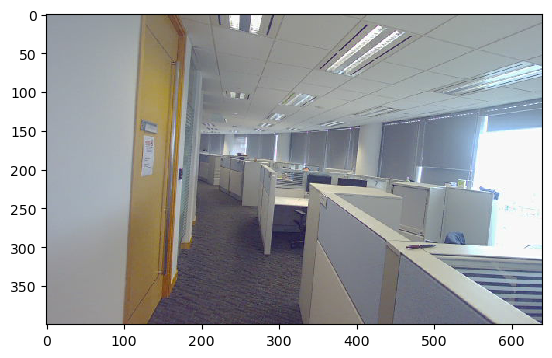

In [4]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    if wait == FRAME_INDEX:
        img1 = data_conversion.topic_to_image(msg)
        break
    wait += 1

plt.imshow(img1)

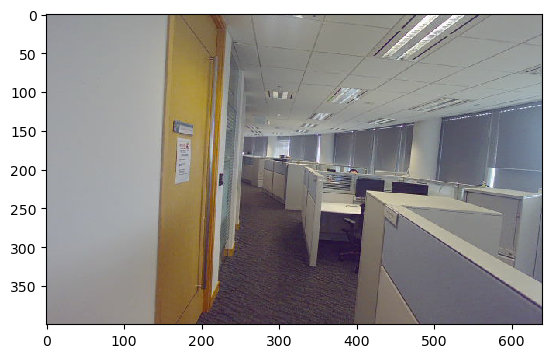

In [5]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    if wait == FRAME_INDEX+GAP_INDEX:
        img2 = data_conversion.topic_to_image(msg)
        break
    wait += 1

plt.imshow(img2)

In [6]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

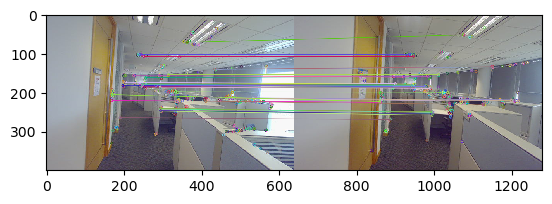

In [7]:
# Draw top matches

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:int(len(matches)*RATIO_THRESHOLD)], None)

plt.imshow(img_matches)

In [8]:
est_depth1 = model.infer_image(np.array(img1)) # HxW raw depth map in numpy
est_depth2 = model.infer_image(np.array(img2)) # HxW raw depth map in numpy

In [9]:
matching_depth1 = data_conversion.interpolate_depth(est_depth1, points1[:int(len(points1)*RATIO_THRESHOLD),:])
matching_depth2 = data_conversion.interpolate_depth(est_depth2, points2[:int(len(points2)*RATIO_THRESHOLD),:])

In [10]:
coord1 = np.zeros((len(matching_depth1), 3), dtype=np.float32)
print(coord1.shape)

coord1[:, 0] = (points1[:int(len(points1)*RATIO_THRESHOLD),0] - cx) * matching_depth1/ fx
coord1[:, 1] = (points1[:int(len(points1)*RATIO_THRESHOLD),1] - cy) * matching_depth1/ fy
coord1[:, 2] = matching_depth1

coord2 = np.zeros((len(matching_depth2), 3), dtype=np.float32)

coord2[:, 0] = (points2[:int(len(points1)*RATIO_THRESHOLD),0] - cx) * matching_depth2/ fx
coord2[:, 1] = (points2[:int(len(points1)*RATIO_THRESHOLD),1] - cy) * matching_depth2/ fy
coord2[:, 2] = matching_depth2

print(coord1[0])
print(coord2[0])

(53, 3)
[-0.50151116  0.9705036   6.454075  ]
[0.7092357 1.0678039 6.006326 ]


In [11]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [12]:
mean1 = np.mean(coord1, axis=0)
translate1 = coord1 - mean1
scale1 = (np.linalg.norm(translate1) ** 2 / len(translate1)) ** 0.5
rescale1 = translate1 / scale1

mean2 = np.mean(coord2, axis=0)
translate2 = coord2 - mean2
scale2 = (np.linalg.norm(translate2) ** 2 / len(translate2)) ** 0.5
rescale2 = translate2 / scale2

# Find the best rotation matrix
best_rotation = np.eye(3)
best_inliers = 0
epsilon = 0.05

for i in range(len(rescale1)):

    rotation = rotation_matrix_from_vectors(rescale1[i], rescale2[i])
    
    inliers = 0
    for j in range(len(rescale1)):
        if np.linalg.norm(rescale2[j] - np.dot(rotation, rescale1[j])) < epsilon:
            inliers += 1


    if inliers > best_inliers:
        best_inliers = inliers
        best_rotation = rotation

print(best_rotation, best_inliers)

[[ 0.98640334 -0.00655491  0.16421108]
 [ 0.00483195  0.99992903  0.01088948]
 [-0.1642708  -0.00994795  0.98636501]] 32


In [13]:
all_coord1 = data_conversion.depth_to_pcd(est_depth1,K)
all_coord2 = data_conversion.depth_to_pcd(est_depth2,K)

all_coord1 = all_coord1 - mean1
all_coord1 = all_coord1 / scale1
all_coord1 = np.dot(all_coord1, best_rotation.T)

all_coord2 = all_coord2 - mean2
all_coord2 = all_coord2 / scale2

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(all_coord1)
pcd.colors = o3d.utility.Vector3dVector(img1.reshape(-1,3) / 255.0) 

o3d.io.write_point_cloud("test1.ply", pcd)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(all_coord2)
pcd.colors = o3d.utility.Vector3dVector(img2.reshape(-1,3) / 255.0)

o3d.io.write_point_cloud("test2.ply", pcd)

True